# Interrupted Time Series

Guide 1: https://www.mdrc.org/sites/default/files/RDD%20Guide_Full%20rev%202016_0.pdf  
Guide 2: https://bfi.uchicago.edu/wp-content/uploads/BFI_WP_201997.pdf  
Guide 3: https://www.princeton.edu/~davidlee/wp/RDDEconomics.pdf

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import json

# Modeling
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

C:\Users\Matheus\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Matheus\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Matheus\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


## Load Data

#### Tratment

In [2]:
# Hate words count
with open(f'../word_counts/count_hate_words_treatment.json') as json_file:
    hate_dict = json.load(json_file)
df_hate_treatment_other = pd.DataFrame(hate_dict, index=['hate'], dtype=int) 
print(f'Number of days included: {df_hate_treatment_other.shape}')

# All words count
with open(f'../word_counts/count_all_words_treatment.json') as json_file:
    all_dict = json.load(json_file)
df_all_treatment_other = pd.DataFrame(all_dict, index=['all'], dtype=int) 
print(f'Number of days included: {df_all_treatment_other.shape}')

# Merge, set columns to integer and sort them
df_treatment = pd.concat([df_hate_treatment_other, df_all_treatment_other])
df_treatment.columns = df_treatment.columns.astype(int)
df_treatment = df_treatment.sort_index(axis=1)

# Then calculate the percentage of hate words
df_treatment.loc['percentage'] = df_treatment.loc['hate']/df_treatment.loc['all']

Number of days included: (1, 4976)
Number of days included: (1, 4976)


In [5]:
df_treatment

,-2852,-2851,-2850,-2845,-2840,-2839,-2837,-2835,-2833,-2831,...,2975,2977,2981,2983,2998,3014,3016,3046,3051,3053
hate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
all,15.0,36.0,15.0,9.0,8.0,6.0,3.0,7.0,4.0,7.0,...,45.0,1.0,6.0,5.0,13.0,7.0,15.0,31.0,3.0,10.0
percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_treatment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, hate to percentage
Columns: 4976 entries, -2852 to 3053
dtypes: float64(4976)
memory usage: 116.6+ KB


In [4]:
# How many columns (days) should we have?
sum([1 for x in range(df_treatment.columns.min(), 
                      df_treatment.columns.max()+1)])

5906

In [6]:
# Fill in missind days with zeros
first_day = df_treatment.columns.min()
last_day = df_treatment.columns.max()
missing_days = [day for day in range(first_day, last_day) if day not in df_treatment.columns.values]
df_treatment[missing_days] = 0
df_treatment = df_treatment.sort_index(axis=1)
df_treatment = df_treatment.copy()

C:\Users\Matheus\Anaconda3\lib\site-packages\pandas\core\frame.py:3640: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value


In [7]:
df_treatment

,-2852,-2851,-2850,-2849,-2848,-2847,-2846,-2845,-2844,-2843,...,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053
hate,0.0,0.0,0.0,0,0,0,0,0.0,0,0,...,0,0,0.0,0,0,0,0,0.0,0,0.0
all,15.0,36.0,15.0,0,0,0,0,9.0,0,0,...,0,0,31.0,0,0,0,0,3.0,0,10.0
percentage,0.0,0.0,0.0,0,0,0,0,0.0,0,0,...,0,0,0.0,0,0,0,0,0.0,0,0.0


#### Control

In [8]:
# Hate words count
with open(f'../word_counts/count_hate_words_control.json') as json_file:
    hate_dict = json.load(json_file)
df_hate_control = pd.DataFrame(hate_dict, index=['hate'], dtype=int) 
print(f'Number of days included: {df_hate_control.shape}')

# All words count
with open(f'../word_counts/count_all_words_control.json') as json_file:
    all_dict = json.load(json_file)
df_all_control = pd.DataFrame(all_dict, index=['all'], dtype=int) 
print(f'Number of days included: {df_all_control.shape}')

# Merge, set columns to integer and sort them
df_control = pd.concat([df_hate_control, df_all_control])
df_control.columns = df_control.columns.astype(int)
df_control = df_control.sort_index(axis=1)

# Then calculate the percentage of hate words
df_control.loc['percentage'] = df_control.loc['hate']/df_control.loc['all']

# Fill in missind days with zeros
first_day = df_control.columns.min()
last_day = df_control.columns.max()
missing_days = [day for day in range(first_day, last_day) if day not in df_control.columns.values]
df_control[missing_days] = 0
df_control = df_control.sort_index(axis=1)
df_control = df_control.copy()

Number of days included: (1, 5023)
Number of days included: (1, 5023)


C:\Users\Matheus\Anaconda3\lib\site-packages\pandas\core\frame.py:3640: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value


In [9]:
df_control

,-2899,-2898,-2897,-2896,-2895,-2894,-2893,-2892,-2891,-2890,...,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023
hate,0.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0.0,0.0,0,0,0.0
all,6.0,0,0,0,0,0,0,0,0,0,...,5.0,0,0,0,0,37.0,22.0,0,0,4.0
percentage,0.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0.0,0.0,0,0,0.0


## Bandwidth Optimization

In [29]:
# DF to store analysis results
RMSEs = pd.DataFrame()

# Test bandwidths in increments of 5 days
for bandwidth in range(30, 366, 5):
    
    # Lists to store values for RMSE calculateion
    truth = []
    preds = []
    
    # Loop over all test days to get RMSE
    for test_day in range(-1, -101, -1):

        # Keep only data within the desired date range
        date_filter = [col for col in df_treatment.columns if col in range(-bandwidth+test_day, test_day+1)]
        df_treatment_filtered = df_treatment[date_filter]
        df_control_filtered = df_control[date_filter]

        # Treatment Before
        df_treatment_before_T = df_treatment_filtered.transpose()
        df_treatment_before_T.drop(columns=['hate', 'all'], inplace=True)
        df_treatment_before_T['exposed'] = 1

        # Control Before
        df_control_before_T = df_control_filtered.transpose()
        df_control_before_T.drop(columns=['hate', 'all'], inplace=True)
        df_control_before_T['exposed'] = 0

        # Merge 
        df = pd.concat([df_treatment_before_T, df_control_before_T])

        # Then convert the index to a feature (time)
        df.reset_index(inplace=True)
        df.columns = ['time', 'percentage', 'exposed']
        df['time_x_exposed'] = df['time'] * df['exposed']

        # Split X and Y
        x = df[df['time'] < test_day].drop(columns='percentage')
        y = df[df['time'] < test_day]['percentage']

        # OLS Regression 
        model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()

        ### RMSE ###
        # Get the samples for testing (first day not included in model training)
        test_treatment = df[(df['time'] == test_day) & (df['exposed'] == 1)]
        test_control = df[(df['time'] == test_day) & (df['exposed'] == 0)]

        # Get X and Y for treatment and control at time -1
        x_test_treat = test_treatment.drop(columns='percentage')
        x_test_treat = [1] + x_test_treat.reset_index(drop=True).iloc[0].tolist() # [1] is the constant
        y_test_treat = test_treatment['percentage']
        y_test_treat = y_test_treat.values[0]

        x_test_contr = test_control.drop(columns='percentage')
        x_test_contr = [1] + x_test_contr.reset_index(drop=True).iloc[0].tolist() # [1] is the constant
        y_test_contr = test_control['percentage']
        y_test_contr = y_test_contr.values[0]

        # Predict
        pred_treat = model.predict(x_test_treat)[0]
        pred_contr = model.predict(x_test_contr)[0]
        
        # Add to lists for RMSE calculation
        truth.extend([y_test_treat, y_test_contr])
        preds.extend([pred_treat, pred_contr])
        
    # Calculate RMSE
    rmse = mean_squared_error(truth, preds, squared=False)
    results = pd.Series(rmse)
    results.name = bandwidth
    RMSEs = pd.concat([RMSEs, results], axis=1)
        
print(f"The optimal bandwidth according to cross-validation RMSE is {RMSEs.T[0].idxmin()} days.")

The optimal bandwidth according to cross-validation RMSE is 230 days.


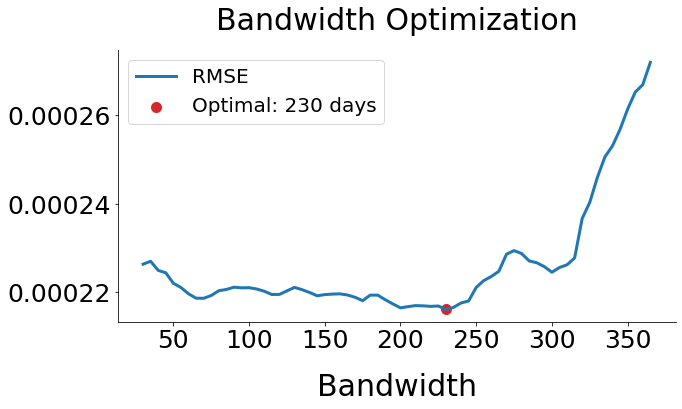

In [30]:
# Create figure
fig, ax = plt.subplots(figsize=(10,5))

# Coefficients
ax.plot(RMSEs.T, label='RMSE', lw=3)
ax.scatter(x=RMSEs.T[0].idxmin(), y=RMSEs.T[0].min(), 
           color='C3', s=100, label=f'Optimal: {RMSEs.T[0].idxmin()} days')

# Text
#plt.legend(fontsize=25)
plt.title('Bandwidth Optimization', size=30, pad=20)
plt.xlabel('Bandwidth', fontsize=30, weight='normal', labelpad=20)
plt.ylabel('', fontsize=30, weight='normal', labelpad=20)

# Axis
plt.legend(fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.locator_params(axis ='y', nbins=6)

# Show
plt.show()

## Interrupted Time Series

### Prepare Data

In [12]:
# Specify the date period under which to calculate means
bandwidth = RMSEs.T[0].idxmin()

# Keep only the data for the desired period
date_filter = [col for col in df_treatment.columns if col in range(-bandwidth, bandwidth)]
df_treatment_filtered = df_treatment[date_filter]
df_control_filtered = df_control[date_filter]

# Split before and after
df_treatment_before = df_treatment_filtered.iloc[:, df_treatment_filtered.columns < 0]
df_treatment_after = df_treatment_filtered.iloc[:, df_treatment_filtered.columns >= 0]
df_control_before = df_control_filtered.iloc[:, df_control_filtered.columns < 0]
df_control_after = df_control_filtered.iloc[:, df_control_filtered.columns >= 0]

# Treatment Before
df_treatment_before_T = df_treatment_before.transpose()
df_treatment_before_T.drop(columns=['hate', 'all'], inplace=True)
df_treatment_before_T['exposed'] = 1
df_treatment_before_T['interrupted'] = 0

# Treatment After
df_treatment_after_T = df_treatment_after.transpose()
df_treatment_after_T.drop(columns=['hate', 'all'], inplace=True)
df_treatment_after_T['exposed'] = 1
df_treatment_after_T['interrupted'] = 1

# Control Before
df_control_before_T = df_control_before.transpose()
df_control_before_T.drop(columns=['hate', 'all'], inplace=True)
df_control_before_T['exposed'] = 0
df_control_before_T['interrupted'] = 0

# Control After
df_control_after_T = df_control_after.transpose()
df_control_after_T.drop(columns=['hate', 'all'], inplace=True)
df_control_after_T['exposed'] = 0
df_control_after_T['interrupted'] = 1

# Merge 
df = pd.concat([df_treatment_before_T, df_treatment_after_T, 
                df_control_before_T, df_control_after_T])

# Then convert the index to a feature (time)
df.reset_index(inplace=True)
df.columns = ['time', 'percentage', 'exposed', 'interrupted']
df['time_x_exposed'] = df['time'] * df['exposed']
df['time_x_interrupted'] = df['time'] * df['interrupted']
df['exposed_x_interrupted'] = df['exposed'] * df['interrupted']
df['time_x_exposed_x_interrupted'] = df['time'] * df['exposed'] * df['interrupted']

In [13]:
# How does the final data look like?
df[(df.time >= -1) & (df.time <= 1)]

,time,percentage,exposed,interrupted,time_x_exposed,time_x_interrupted,exposed_x_interrupted,time_x_exposed_x_interrupted
229,-1,0.001202,1,0,-1,0,0,0
230,0,0.000929,1,1,0,0,1,0
231,1,0.001553,1,1,1,1,1,1
689,-1,0.000178,0,0,0,0,0,0
690,0,0.000200,0,1,0,0,0,0
691,1,0.000125,0,1,0,1,0,0


### Regression

In [14]:
# Split X and Y
x = df.drop(columns='percentage')
y = df['percentage']

# OLS Regression Results 
model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
results = model.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:             percentage   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     338.3
Date:                Sun, 06 Feb 2022   Prob (F-statistic):          1.90e-248
Time:                        17:46:56   Log-Likelihood:                 6417.0
No. Observations:                 920   AIC:                        -1.282e+04
Df Residuals:                     912   BIC:                        -1.278e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

| Feature | Meaning|
| :- | :- |
| const | The pre-treatment baseline for the control group |
| time | The pre-treatment trend for the control group |
| exposed | The incremental baseline for the treatment group | 
| interrupted | The incremental baseline after treatment/placebo administration |
| time_x_exposed | The incremental trend for the treatment group |
| time_x_interrupted | The incremental trend after treatment/placebo administration |
| **exposed_x_interrupted** | **The incremental baseline on treatment group after treatment administration** |
| time_x_exposed_interrupted | The incremental trend for the treatment group after treatment administration |

**Effect Size**  
 _exposed_x_interrupted_ = The effect size from applying the treatment. 

**Baseline Values**  
_const_ = The pre-treatment baseline for the control group.  
_const_ + _exposed_ = The pre-treatment baseline for the treatment group.  
_const_ + _interrupted_ = The post-treatment baseline for the control group.  
_const_ + _interrupted_ + _exposed_ + _exposed_x_interrupted_ = The post-treatment baseline for the treatment group.  

**Trends**  
_time_ = The pre-treatment trend for the control group.  
_time_ + _time_x_exposed_ = The pre-treatment trend for the treatment group.  
_time_ + _time_x_interrupted_ = The post-treatment trend for the control group.  
_time_ + _time_x_exposed_ + _time_x_interrupted_ + _time_x_exposed_interrupted_ = The post-treatment trend for the treatment group.  

### Plot

In [15]:
## Generate Regression Lines ## 

# Get X
X_treatment_before = df[(df.exposed == 1) & (df.interrupted == 0)].drop(columns='percentage')
X_treatment_after = df[(df.exposed == 1) & (df.interrupted == 1)].drop(columns='percentage')
X_control_before = df[(df.exposed == 0) & (df.interrupted == 0)].drop(columns='percentage')
X_control_after = df[(df.exposed == 0) & (df.interrupted == 1)].drop(columns='percentage')

# Predict to get Y
y_treatment_before = model.predict(sm.add_constant(X_treatment_before, has_constant='add'))
y_treatment_after = model.predict(sm.add_constant(X_treatment_after, has_constant='add'))
y_control_before = model.predict(sm.add_constant(X_control_before, has_constant='add'))
y_control_after = model.predict(sm.add_constant(X_control_after, has_constant='add'))

# Change indexes on predition to relative times
y_treatment_before.index = X_treatment_before.time
y_treatment_after.index = X_treatment_after.time
y_control_before.index = X_control_before.time
y_control_after.index = X_control_after.time

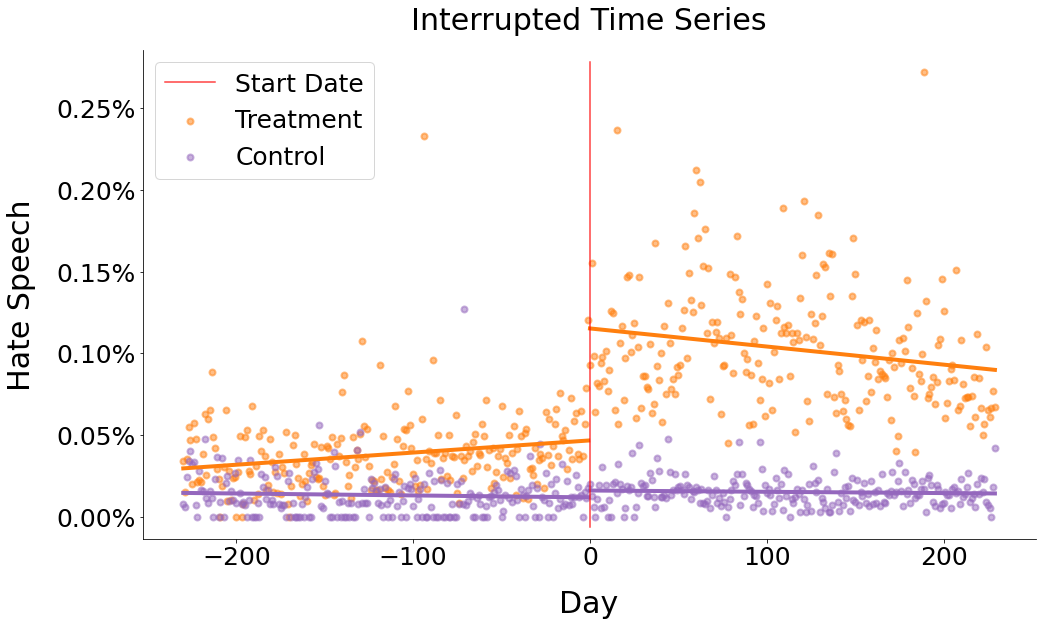

In [16]:
# Get X and Y
x = df.drop(columns='percentage')
y = df['percentage']

# Create figure
fig, ax = plt.subplots(figsize=(16,9))

# Scatter Plot of Data
plt.scatter(x=df_treatment_filtered.T.index, y=df_treatment_filtered.T['percentage'], lw=2, color='C1', alpha=0.5, label=f'Treatment')
plt.scatter(x=df_control_filtered.T.index, y=df_control_filtered.T['percentage'], lw=2, color='C4', alpha=0.5, label='Control')

# Add Regression Lines
plt.plot(y_treatment_before, color='C1', lw=4)
plt.plot(y_treatment_after, color='C1', lw=4)
plt.plot(y_control_before, color='C4', lw=4)
plt.plot(y_control_after, color='C4', lw=4)

# Add join date
plt.axvline(x=0, color='red', ymin=0.025, ymax=0.975, alpha=0.75, label=f'Join Date')

# Text
plt.legend(fontsize=25)
plt.title('Interrupted Time Series', size=30, pad=20)
plt.xlabel('Day', fontsize=30, weight='normal', labelpad=20)
plt.ylabel('Hate Speech', fontsize=30, weight='normal', labelpad=20)

# Axis
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.locator_params(axis ='y', nbins=6)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show
plt.show()

## Sensitivity Analysis

In [17]:
# DF to store analysis results
coefficients = pd.DataFrame()
CI_05 = pd.DataFrame()
CI_95 = pd.DataFrame()
Pvalues = pd.DataFrame()

# Iterate over all possible bandwidths
for bandwidth in range(30, 366, 1):
    
    # Keep only data within the desired date range
    date_filter = [col for col in df_treatment.columns if col in range(-bandwidth, bandwidth)]
    df_treatment_filtered = df_treatment[date_filter]
    df_control_filtered = df_control[date_filter]

    # Split before and after
    df_treatment_before = df_treatment_filtered.iloc[:, df_treatment_filtered.columns < 0]
    df_treatment_after = df_treatment_filtered.iloc[:, df_treatment_filtered.columns >= 0]
    df_control_before = df_control_filtered.iloc[:, df_control_filtered.columns < 0]
    df_control_after = df_control_filtered.iloc[:, df_control_filtered.columns >= 0]
    
    # Treatment Before
    df_treatment_before_T = df_treatment_before.transpose()
    df_treatment_before_T.drop(columns=['hate', 'all'], inplace=True)
    df_treatment_before_T['exposed'] = 1
    df_treatment_before_T['interrupted'] = 0

    # Treatment After
    df_treatment_after_T = df_treatment_after.transpose()
    df_treatment_after_T.drop(columns=['hate', 'all'], inplace=True)
    df_treatment_after_T['exposed'] = 1
    df_treatment_after_T['interrupted'] = 1

    # Control Before
    df_control_before_T = df_control_before.transpose()
    df_control_before_T.drop(columns=['hate', 'all'], inplace=True)
    df_control_before_T['exposed'] = 0
    df_control_before_T['interrupted'] = 0

    # Control After
    df_control_after_T = df_control_after.transpose()
    df_control_after_T.drop(columns=['hate', 'all'], inplace=True)
    df_control_after_T['exposed'] = 0
    df_control_after_T['interrupted'] = 1

    # Merge 
    df = pd.concat([df_treatment_before_T, df_treatment_after_T, 
                    df_control_before_T, df_control_after_T])

    # Then convert the index to a feature (time)
    df.reset_index(inplace=True)
    df.columns = ['time', 'percentage', 'exposed', 'interrupted']
    df['time_x_exposed'] = df['time'] * df['exposed']
    df['time_x_interrupted'] = df['time'] * df['interrupted']
    df['exposed_x_interrupted'] = df['exposed'] * df['interrupted']
    df['time_x_exposed_x_interrupted'] = df['time'] * df['exposed'] * df['interrupted']
    
    # Split X and Y
    x = df.drop(columns='percentage')
    y = df['percentage']

    # OLS Regression 
    model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
    
    # Get coefficients and confidence intervals
    model_coefs = model.params
    model_coefs.name = bandwidth
    coefficients = pd.concat([coefficients, model_coefs], axis=1)
    bottom_CI = model.conf_int()[0]
    bottom_CI.name = bandwidth
    CI_05 = pd.concat([CI_05, bottom_CI], axis=1)
    top_CI = model.conf_int()[1]
    top_CI.name = bandwidth
    CI_95 = pd.concat([CI_95, top_CI], axis=1)
    pvalues = model.pvalues
    pvalues.name = bandwidth
    Pvalues = pd.concat([Pvalues, pvalues], axis=1)

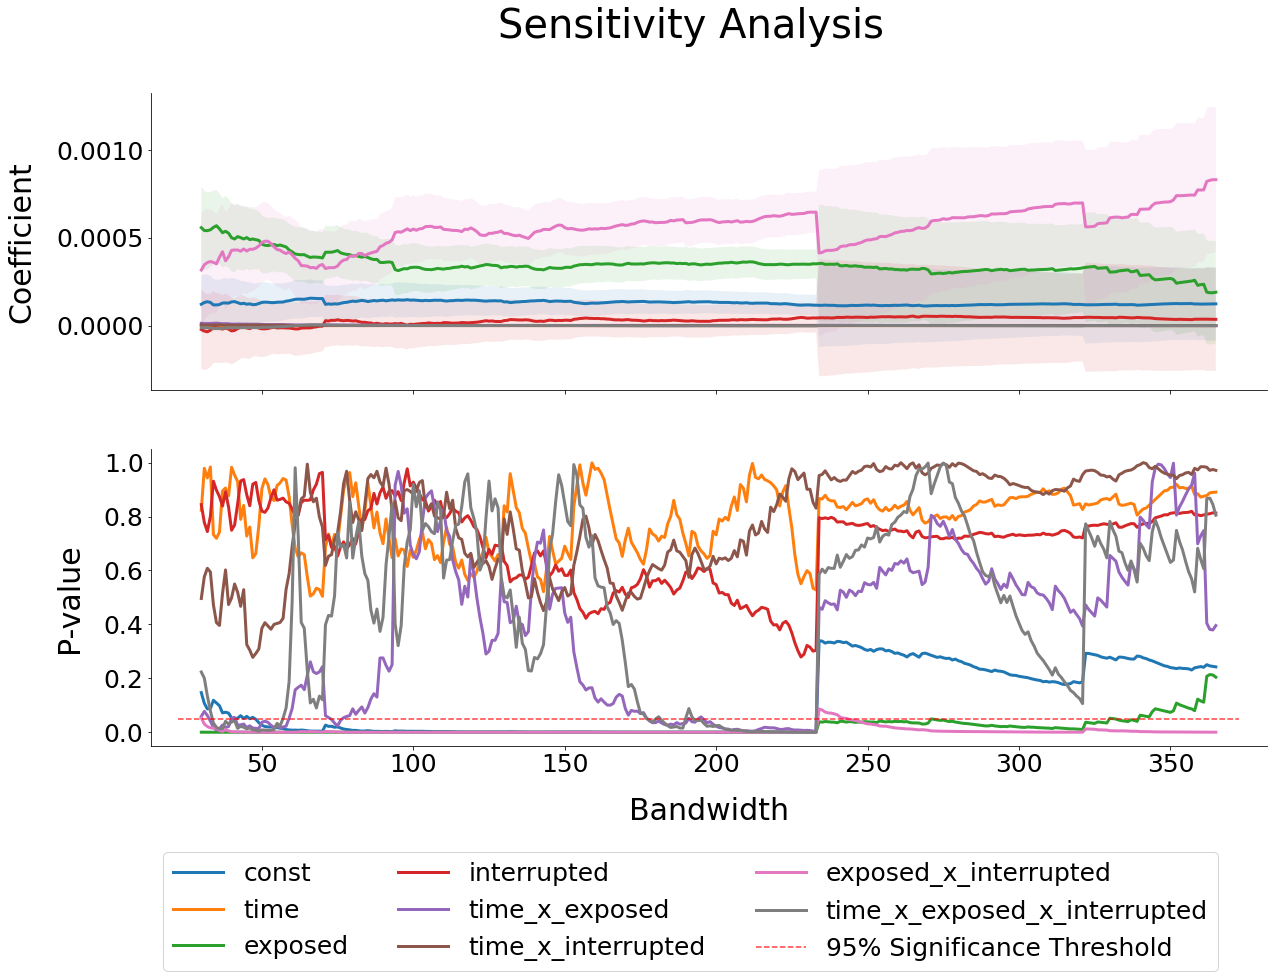

In [18]:
# Create figure
fig, ax = plt.subplots(nrows=2, figsize=(20,12), sharex=True)

plt.suptitle("Sensitivity Analysis", size=40)

### Coefficients ###
plt.sca(ax[0])

# Lines and Error bars
ax[0].plot(coefficients.T, label=coefficients.T.columns, lw=3)
for idx, beta in enumerate(coefficients.T.columns):
    ax[0].fill_between(coefficients.T.index, 
                    CI_05.T[beta], 
                    CI_95.T[beta], 
                    facecolor=f'C{idx}', 
                    alpha=0.1,
                    interpolate=True)

# Axis
plt.xlabel('', fontsize=30, weight='normal', labelpad=20)
plt.ylabel('Coefficient', fontsize=30, weight='normal', labelpad=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].locator_params(axis ='y', nbins=6)


### p-values ###
plt.sca(ax[1])
ax[1].plot(Pvalues.T, lw=3)

# 0.05 Threshold
ax[1].axhline(y=0.05, color='red', xmin=0.025, xmax=0.975, alpha=0.75, label='95% Significance Threshold', ls='--')

# Axis
plt.xlabel('Bandwidth', fontsize=30, weight='normal', labelpad=20)
plt.ylabel('P-value', fontsize=30, weight='normal', labelpad=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].locator_params(axis ='y', nbins=6)

# Put a legend below the plot
plt.figlegend(loc='lower center', fontsize=25, ncol=3, bbox_to_anchor=(0.5, -0.15))

# Show
plt.show()

In [19]:
df_treatment[[x for x in range(230,236)]]

,230,231,232,233,234,235
hate,27.00000,27.000000,41.000000,1442.000000,39.000000,42.000000
all,46574.00000,42367.000000,44258.000000,51021.000000,47818.000000,48903.000000
percentage,0.00058,0.000637,0.000926,0.028263,0.000816,0.000859


In [20]:
df_treatment[[x for x in range(-235,-225)]]

,-235,-234,-233,-232,-231,-230,-229,-228,-227,-226
hate,3.000000,1.000000,3.000000,1.000000,2.000000,3.00000,1.000000,3.000000,5.000000,6.000000
all,14057.000000,8104.000000,7753.000000,8634.000000,7041.000000,8835.00000,6762.000000,8542.000000,9132.000000,12831.000000
percentage,0.000213,0.000123,0.000387,0.000116,0.000284,0.00034,0.000148,0.000351,0.000548,0.000468


## Falsification (Placebo) Tests

In [21]:
# DF to store analysis results
WALDs = pd.DataFrame()

# Fix the number of days and instead shift the treatment start point
bandwidth = RMSEs.T[0].idxmin()

# Test all possible days as breakpoint, but keep at least 20% of the data from the other period for evaluation stability
for shift in range(-round(bandwidth*0.5), +(round(bandwidth*0.5)+1), 1):  
    
    # Keep only data within the desired date range
    date_filter = [col for col in df_treatment.columns if col in range(-bandwidth+shift, bandwidth+shift)]
    df_treatment_filtered = df_treatment[date_filter]
    df_control_filtered = df_control[date_filter]

    # Split before and after
    df_treatment_before = df_treatment_filtered.iloc[:, df_treatment_filtered.columns < shift]
    df_treatment_after = df_treatment_filtered.iloc[:, df_treatment_filtered.columns >= shift]
    df_control_before = df_control_filtered.iloc[:, df_control_filtered.columns < shift]
    df_control_after = df_control_filtered.iloc[:, df_control_filtered.columns >= shift]
    
    # Treatment Before
    df_treatment_before_T = df_treatment_before.transpose()
    df_treatment_before_T.drop(columns=['hate', 'all'], inplace=True)
    df_treatment_before_T['exposed'] = 1
    df_treatment_before_T['interrupted'] = 0

    # Treatment After
    df_treatment_after_T = df_treatment_after.transpose()
    df_treatment_after_T.drop(columns=['hate', 'all'], inplace=True)
    df_treatment_after_T['exposed'] = 1
    df_treatment_after_T['interrupted'] = 1

    # Control Before
    df_control_before_T = df_control_before.transpose()
    df_control_before_T.drop(columns=['hate', 'all'], inplace=True)
    df_control_before_T['exposed'] = 0
    df_control_before_T['interrupted'] = 0

    # Control After
    df_control_after_T = df_control_after.transpose()
    df_control_after_T.drop(columns=['hate', 'all'], inplace=True)
    df_control_after_T['exposed'] = 0
    df_control_after_T['interrupted'] = 1

    # Merge 
    df = pd.concat([df_treatment_before_T, df_treatment_after_T, 
                    df_control_before_T, df_control_after_T])

    # Then convert the index to a feature (time)
    df.reset_index(inplace=True)
    df.columns = ['time', 'percentage', 'exposed', 'interrupted']
    df['time_x_exposed'] = df['time'] * df['exposed']
    df['time_x_interrupted'] = df['time'] * df['interrupted']
    df['exposed_x_interrupted'] = df['exposed'] * df['interrupted']
    df['time_x_exposed_x_interrupted'] = df['time'] * df['exposed'] * df['interrupted']
    
    # Split X and Y
    x = df.drop(columns='percentage')
    y = df['percentage']

    # OLS Regression 
    model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
    
    # Wald Test
    wald = model.wald_test(', '.join(x.columns.tolist()), scalar=True)
    result = pd.Series(wald.fvalue)
    result.name = shift
    WALDs = pd.concat([WALDs, result], axis=1)
        
print(f"The optimal breakpoint shift according to Wald Test's F-Statistic is {WALDs.T[0].idxmax()} days.")

The optimal breakpoint shift according to Wald Test's F-Statistic is -1 days.


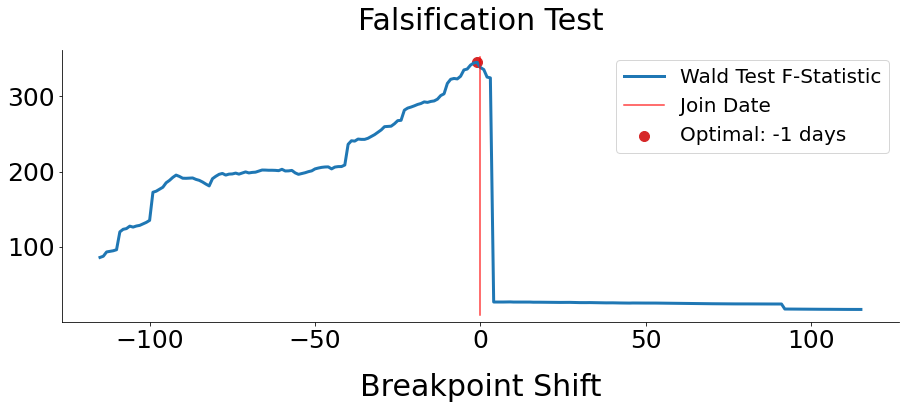

In [32]:
# Create figure
fig, ax = plt.subplots(figsize=(15,5))

# Coefficients
ax.plot(WALDs.T, label='Wald Test F-Statistic', lw=3)
ax.scatter(x=WALDs.T[0].idxmax(), y=WALDs.T[0].max(), 
           color='C3', s=100, label=f'Optimal: {WALDs.T[0].idxmax()} days')

# Add join date
plt.axvline(x=0, color='red', ymin=0.025, ymax=0.975, alpha=0.75, label=f'Join Date')

# Text
#plt.legend(fontsize=25)
plt.title('Falsification Test', size=30, pad=20)
plt.xlabel('Breakpoint Shift', fontsize=30, weight='normal', labelpad=20)
plt.ylabel('', fontsize=30, weight='normal', labelpad=20)

# Axis
#plt.xlim([-5,5])
plt.legend(fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.locator_params(axis ='y', nbins=6)

# Show
plt.show()

In [23]:
df[(df.time >= -2) & (df.time <= 5) & (df.exposed == 1)]

,time,percentage,exposed,interrupted,time_x_exposed,time_x_interrupted,exposed_x_interrupted,time_x_exposed_x_interrupted
113,-2,0.000789,1,0,-2,0,0,0
114,-1,0.001202,1,0,-1,0,0,0
115,0,0.000929,1,0,0,0,0,0
116,1,0.001553,1,0,1,0,0,0
117,2,0.000982,1,0,2,0,0,0
118,3,0.000642,1,0,3,0,0,0
119,4,0.000817,1,0,4,0,0,0
120,5,0.000799,1,0,5,0,0,0


# End